In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.3)
import warnings 

from itertools import product

%matplotlib inline

### Загрузка временного ряда

**Ряд:**

In [2]:
brent_df = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
brent_df.sort_index(inplace=True)
brent_df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


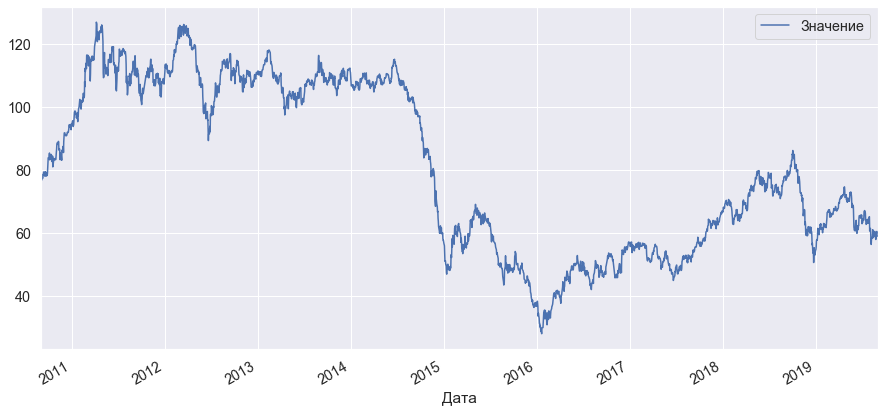

In [3]:
plt.figure(figsize=(15, 7))
brent_df['Значение'].plot()
plt.legend(loc='best')
plt.show()

**Курс доллара:**

In [4]:
ruble_dollar = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
ruble_dollar.drop(columns=['nominal', 'cdx'], inplace=True)
ruble_dollar.rename(columns={'curs': 'dollar'}, inplace=True)
ruble_dollar.head()

,dollar
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


**Курс евро:**

In [5]:
ruble_euro = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
ruble_euro.drop(columns=['nominal', 'cdx'], inplace=True)
ruble_euro.rename(columns={'curs': 'euro'}, inplace=True)
ruble_euro.head()

,euro
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


Формируем из них датафрейм:

In [6]:
brent_df = pd.concat([brent_df['Значение'], ruble_dollar, ruble_euro], axis=1)

In [7]:
brent_df['dollar'].fillna(method='ffill', inplace=True)
brent_df['euro'].fillna(method='ffill', inplace=True)

In [8]:
brent_df['Значение'] = brent_df['Значение'] - brent_df['Значение'].shift(1)
brent_df['dollar'] = brent_df['dollar'] - brent_df['dollar'].shift(1)
brent_df['euro'] = brent_df['euro'] - brent_df['euro'].shift(1)

In [9]:
brent_df.dropna(inplace=True)
brent_df.head(10)

,Значение,dollar,euro
2010-09-02,0.52,-0.0668,0.1527
2010-09-03,-0.32,-0.1143,0.1247
2010-09-04,0.05,0.0064,0.0604
2010-09-05,0.01,0.0000,0.0000
2010-09-06,0.24,0.0000,0.0000
2010-09-07,0.39,-0.1151,0.1215
2010-09-08,0.67,0.1548,-0.1505
2010-09-09,-0.72,0.1554,-0.0267
2010-09-10,1.20,-0.0072,-0.1080
2010-09-11,-0.05,0.0136,0.0049


**Месячный ресемплинг:**

In [10]:
brent_weekly = brent_df.resample('W').mean()
brent_weekly.dropna(inplace=True)
brent_weekly.head()

,Значение,dollar,euro
2010-09-05,0.065000,-0.043675,0.084450
2010-09-12,0.288333,0.033583,-0.026467
2010-09-19,-0.078000,0.025720,0.224980
2010-09-26,0.114000,-0.015900,0.145300
2010-10-03,0.974000,-0.087080,0.035860


### Загрузка статистических модулей и библиотек

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Определение максимальных границ для $p, P, d, D, q, Q$

In [12]:
adfuller(brent_weekly['Значение'], regression='ctt') # ‘ctt’ : constant, and linear and quadratic trend.

(-21.471183807804888,
 0.0,
 0,
 468,
 {'1%': -4.396057909159001,
  '5%': -3.845067196761952,
  '10%': -3.5611044444893207},
 790.8384808731698)

Ряд согласно критерию Дики-Фуллера стационарен, визуально объяснимой сезонности в нем не наблюдается.

Построим ACF и PACF:

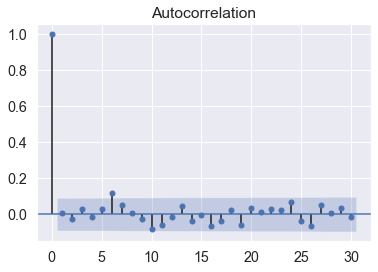

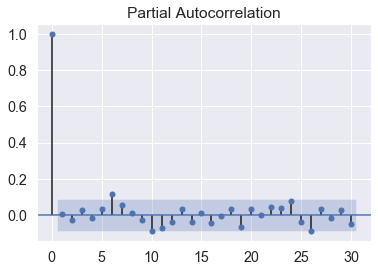

In [13]:
plot_acf(brent_weekly['Значение'], lags=30)
plt.show()

plot_pacf(brent_weekly['Значение'], lags=30)
plt.show()

Пусть $p = 1$ и $q = 1$, остальные нулевые.

### Поиск оптимальной модели ARIMA

**Набор параметров:**

In [14]:
S = 0
d, D = 0, 0
p, P = 6, 0
q, Q = 6, 0

ps, Ps = np.arange(0, p + 1), np.arange(0, P + 1)
qs, Qs = np.arange(0, q + 1), np.arange(0, Q + 1)

In [15]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

49

**Перебор параметров:**

In [16]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for n, param in enumerate(parameters_list):
    try:
        model=SARIMAX(brent_weekly['Значение'], order=(param[0], d, param[1]), 
                      seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    except:
        continue
    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 41.5 s


Топ-5 моделей

In [17]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
0,"(0, 0, 0, 0)",812.031243
37,"(5, 2, 0, 0)",812.686434
19,"(2, 5, 0, 0)",813.007314
23,"(3, 2, 0, 0)",813.734775
16,"(2, 2, 0, 0)",813.835783


**Лучшая модель:**

In [18]:
print(opt_model.summary())

                           Statespace Model Results                           
Dep. Variable:               Значение   No. Observations:                  469
Model:                        SARIMAX   Log Likelihood                -405.016
Date:                Mon, 16 Dec 2019   AIC                            812.031
Time:                        10:08:04   BIC                            816.182
Sample:                             0   HQIC                           813.664
                                - 469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3293      0.014     23.657      0.000       0.302       0.357
Ljung-Box (Q):                       36.14   Jarque-Bera (JB):               178.18
Prob(Q):                              0.64   Pr

**Анализ остатков:**

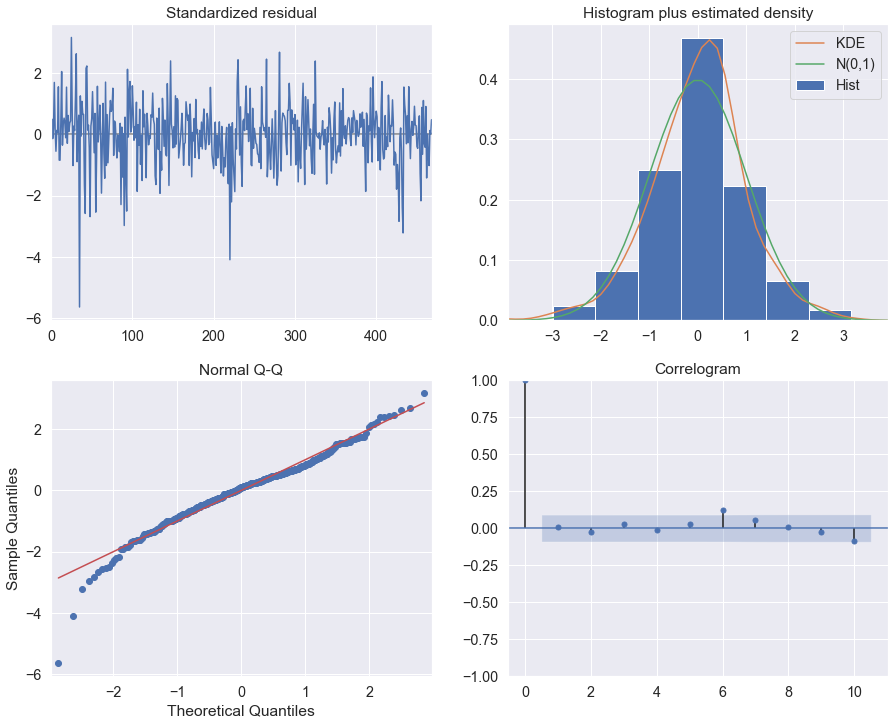

In [19]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному.

In [20]:
adfuller(opt_model.resid)

(-21.425335444973058,
 0.0,
 0,
 468,
 {'1%': -3.4444002781824477,
  '5%': -2.867735576537528,
  '10%': -2.57007000456571},
 787.6402942816185)

Согласно критерию Дики-Фуллера остатки стационарны.

### Создание признаков

Добавим историю глубиной 5:

In [21]:
ps = np.arange(1, 5+1)

In [22]:
for i in ps:
    brent_weekly[f'p{i}'] = brent_weekly['Значение'].shift(i)
    
brent_weekly.dropna(inplace=True)    
brent_weekly.head()

,Значение,dollar,euro,p1,p2,p3,p4,p5
2010-10-10,0.100000,-0.175200,-0.06084,0.974,0.114,-0.078,0.288333,0.065000
2010-10-17,-0.314000,0.004580,0.09736,0.100,0.974,0.114,-0.078000,0.288333
2010-10-24,0.076000,0.122100,0.09684,-0.314,0.100,0.974,0.114000,-0.078000
2010-10-31,0.038000,0.036180,-0.02070,0.076,-0.314,0.100,0.974000,0.114000
2010-11-07,0.891667,-0.001867,0.07330,0.038,0.076,-0.314,0.100000,0.974000


### Разделение данных на train и test

In [23]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

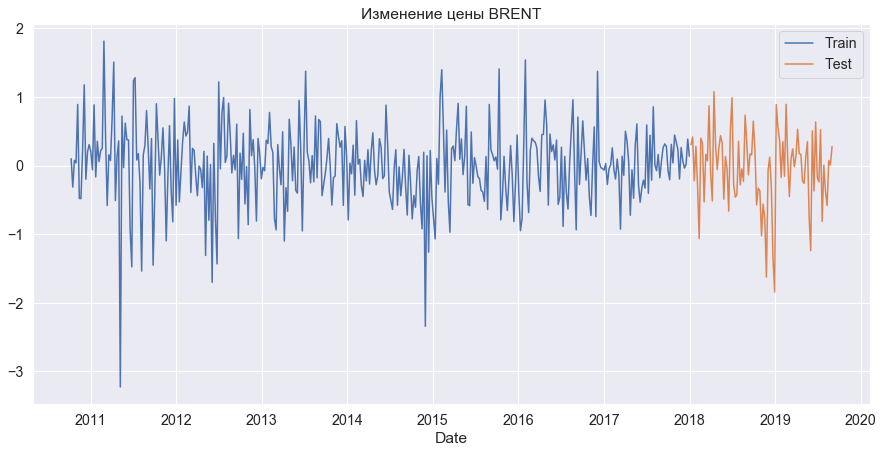

In [24]:
train, test = split_data_b(brent_weekly, '2018-01-01')

plt.figure( figsize=(15, 7))
plt.plot(train.index,train.iloc[:,0], label='Train' )
plt.plot(test.index,test.iloc[:,0], label='Test')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.legend(loc='best')
plt.show()

In [25]:
X_train = brent_weekly.iloc[:train.shape[0], 1:]
y_train = brent_weekly.iloc[:train.shape[0], 0]
X_test = brent_weekly.iloc[train.shape[0]:, 1:]
y_test = brent_weekly.iloc[train.shape[0]:, 0]

### Обучение модели

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [28]:
model_g = GradientBoostingRegressor(max_depth=8, random_state=21, n_estimators=1000)

In [29]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Прямое прогнозирование

In [30]:
gb_pred = pd.Series(model_g.predict(X_test),
                    index=y_test.index)

**Наиболее важные признаки:**

In [31]:
feature_importances = pd.Series(model_g.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

dollar    0.210045
p2        0.154030
p4        0.146977
p1        0.137831
p5        0.126437
p3        0.117182
euro      0.107498
dtype: float64

### Рекурсивное прогнозирование

Основная идея реализации - работаем в копии того же датафрейма, с границы начала тестовых данных.

In [32]:
i_test = X_train.shape[0]

In [34]:
df_rec = brent_weekly.copy()

In [36]:
print(X_test.head(1).index[0])

2018-01-07 00:00:00


**Начало исходной тестовой части данных:**

In [37]:
df_rec.loc[df_rec.index.get_level_values(df_rec.index.name) >= '2018-01-07'].head(5)

,Значение,dollar,euro,p1,p2,p3,p4,p5
2018-01-07,0.305,0.00000,0.00000,0.136667,0.386000,0.016000,-0.036000,0.064000
2018-01-14,0.416,-0.12090,-0.16164,0.305000,0.136667,0.386000,0.016000,-0.036000
2018-01-21,-0.222,0.03156,0.20040,0.416000,0.305000,0.136667,0.386000,0.016000
2018-01-28,0.282,-0.13208,0.01254,-0.222000,0.416000,0.305000,0.136667,0.386000
2018-02-04,-0.304,0.08650,0.03696,0.282000,-0.222000,0.416000,0.305000,0.136667


**Реализация рекурсии (обновление с учетом конечной точки истории, разниц и скользуящих средних отсчетов):**

In [38]:
h = 10

for i in range(10):
    df_rec.iloc[i+i_test+1, 0] = model_g.predict(df_rec.iloc[i+i_test, 1:].values.reshape(1, 7))[0]
    
    df_rec.iloc[i+i_test+1, 3] = df_rec.iloc[i+i_test+1-1, 0]
    df_rec.iloc[i+i_test+1, 4] = df_rec.iloc[i+i_test+1-1-1, 0]
    df_rec.iloc[i+i_test+1, 5] = df_rec.iloc[i+i_test+1-1-2, 0]
    df_rec.iloc[i+i_test+1, 6] = df_rec.iloc[i+i_test+1-1-3, 0]
    df_rec.iloc[i+i_test+1, 7] = df_rec.iloc[i+i_test+1-1-4, 0]

**Начало обновленной тестовой части данных:**

In [39]:
df_rec.loc[df_rec.index.get_level_values(df_rec.index.name) >= '2018-01-07'].head(5)

,Значение,dollar,euro,p1,p2,p3,p4,p5
2018-01-07,0.305000,0.00000,0.00000,0.136667,0.386000,0.016000,-0.036000,0.064000
2018-01-14,-0.394432,-0.12090,-0.16164,0.305000,0.136667,0.386000,0.016000,-0.036000
2018-01-21,0.095696,0.03156,0.20040,-0.394432,0.305000,0.136667,0.386000,0.016000
2018-01-28,-0.211180,-0.13208,0.01254,0.095696,-0.394432,0.305000,0.136667,0.386000
2018-02-04,0.264540,0.08650,0.03696,-0.211180,0.095696,-0.394432,0.305000,0.136667


**10 тестовых отсчетов:**
    - прямое прогнозирование (GB);
    - рекурсивное прогнозирование (GB with recursion).

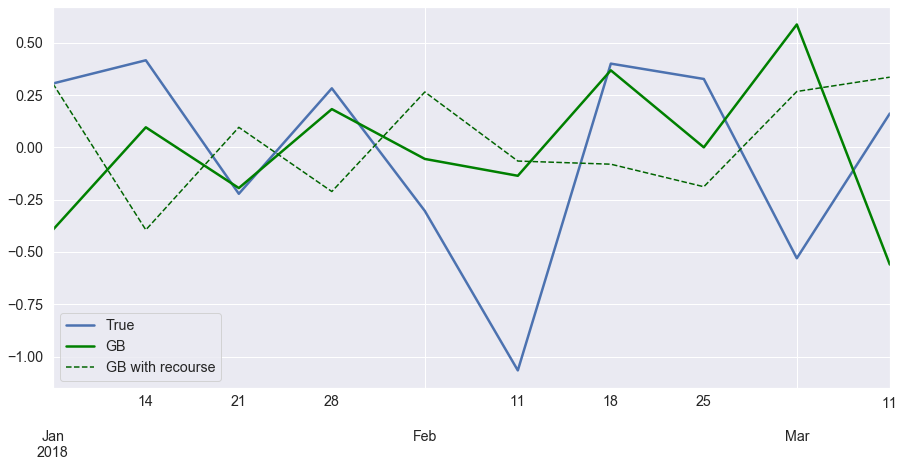

In [40]:
plt.figure(figsize=(15, 7))

y_test[:h].plot(label='True', lw=2.5)

gb_pred[:h].plot(label='GB', c='green', lw=2.5)

test_gb_rec = df_rec.iloc[i_test:i_test+h, 0]
test_gb_rec.plot(label='GB with recourse', c='darkgreen', ls='--')

plt.legend(loc='best')
plt.show()

**Вывод:** на данном участке нельзя сказать, что рекурсивный прогноз ведет себя адекватно в плане динамики (хотя амплитуда у него приемлемая). Возможно, стоит рассмотреть иной порядок модели.